# **Predictive Analytics for Business Retention: Using ML to Identify Factors Affecting Business Lifespan in San Francisco’s District 3**

## **Overview**
Understanding the factors that influence business retention and longevity is vital for City of San Francisco, Funding departments. In this analysis, we aim to leverage **Predictive Modeling** and **Machine Learning (ML)** techniques to identify key variables such as location, license type, and business age that impact business lifespan in **San Francisco’s District 3**.

This project will develop a **predictive model** that can estimate the durability and survival probability of businesses in the area, offering valuable insights for business owners and stakeholders to make informed decisions.

## **Objective**
- **Primary Goal**: Predict the longevity and retention probability of businesses in District 3 using machine learning models.
- **Key Features**: Examine variables like business location, license type, and age to determine which factors most significantly influence business lifespan.

## **Key Factors Impacting Business Longevity**

### **1. Location**:
   - The geographic location of a business plays a critical role in its chances of survival. Factors such as neighborhood, economic zone, and the specific supervisor district may directly affect business sustainability.
   - For this project, **location-based features** (e.g., neighborhood, economic zone) will be incorporated into the model.

### **2. License Type**:
   - Different types of businesses, depending on their industry (e.g., **Restaurant**, **Retail**, **Services**), face varying challenges that affect their survival rates.
   - We will consider the **license type** as a key feature to determine how it influences the longevity of businesses.

### **3. Business Age**:
   - Older businesses may have more established customer bases and reputations, giving them a better chance of survival compared to newer businesses.
   - **Business age** will be examined to determine its relationship with retention and survival probability.

### **4. Financial Metrics**:
   - Financial factors such as **tax rates** (e.g., parking tax, transient occupancy tax) could provide insight into a business’s financial health, which in turn can affect its ability to continue operating.
   - These **financial variables** will be integrated into the model to assess their impact on business longevity.





# Import Structure

This notebook is organized into clearly defined sections to improve readability and modularity:

## 1. General
Imports core libraries for data handling (`pandas`, `numpy`), date operations, and suppressing warnings.

## 2. Modeling
Includes tools for data preprocessing, feature engineering, dimensionality reduction, and survival analysis using `scikit-learn` and `lifelines`.

## 3. Visuals
Handles data visualization using `matplotlib` and `seaborn` for plots and charts.


In [1]:

# =========================
# General
# =========================

import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# =========================
# Modeling
# =========================

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from lifelines import CoxPHFitter, KaplanMeierFitter

# =========================
# Visuals
# =========================
import matplotlib.pyplot as plt
import seaborn as sns

import joblib


## 1. Load and Inspect Data

This section loads the San Francisco registered businesses dataset and performs a quick initial inspection using:

- `df.head()`: Displays the first few rows of the dataset to preview the structure.
- `df.info()`: Provides an overview of column types, non-null counts, and memory usage.


In [2]:
# =========================
# Load and Inspect Data
# =========================
df = pd.read_csv('../data/sf_registered_business.csv')
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342996 entries, 0 to 342995
Data columns (total 37 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   uniqueid                           342996 non-null  object 
 1   ttxid                              342996 non-null  object 
 2   certificate_number                 342996 non-null  int64  
 3   ownership_name                     342995 non-null  object 
 4   dba_name                           342695 non-null  object 
 5   full_business_address              342980 non-null  object 
 6   city                               342790 non-null  object 
 7   state                              342340 non-null  object 
 8   business_zip                       342298 non-null  float64
 9   dba_start_date                     342996 non-null  object 
 10  dba_end_date                       182007 non-null  object 
 11  location_start_date                3429

## 1. Data Cleaning and Preprocessing

This section focuses on preparing the San Francisco business registration dataset for reliable analysis by standardizing text, correcting errors, and creating derived features.

### 2. Standardizing City Names
All city names are converted to lowercase to ensure uniformity and prevent mismatches due to capitalization inconsistencies.

### 3. Correcting Misspellings of "San Francisco"
A comprehensive list of known typos and variations of "San Francisco" is replaced with the correct standardized name. This is essential for accurately filtering and analyzing records related to San Francisco.

### 4. Renaming Columns
Machine-generated column names related to geographic regions are renamed to more descriptive and readable labels, improving the interpretability of the dataset.

### 5. Filtering Data for San Francisco District 3
The dataset is filtered to include only businesses located in San Francisco and specifically within Supervisor District 3. This focused subset enables targeted analysis of a specific geographic region.

### 6. Converting Dates and Calculating Business Age
All relevant date columns are converted to proper datetime formats. A new column, `business_age`, is created by calculating the number of years each business has been active, using the difference between start and end dates (or the current date if still active).

### 7. Handling Administrative Closures
Businesses marked as “Administratively Closed” are encoded as inactive. Missing entries are treated as active, and a new binary column is created to reflect this status clearly.


In [3]:
# =========================
# Data Cleaning
# =========================

df['city'] = df['city'].str.lower()
print("Unique City Names After Converting to Lowercase:")
print(df['city'].unique())

def fix_san_francisco_typos(df, city_column):
    """Replaces a comprehensive list of 'San Francisco' typos with the correct name."""
    corrections = {
        'san francis': 'san francisco',
        'san fracisco': 'san francisco',
        'san franciso': 'san francisco',
        'san francsico': 'san francisco',
        'sanfrancisco': 'san francisco',
        'san\xa0 francisco': 'san francisco',
        'san fransico': 'san francisco',
        'san franciaco': 'san francisco',
        'sa francisco': 'san francisco',
        'sab francisco': 'san francisco',
        'san francico': 'san francisco',
        'san francisc': 'san francisco',
        'san fransisco': 'san francisco',
        'sf': 'san francisco',
        'san fracnisco': 'san francisco',
        'san francisco, ca': 'san francisco',
        'san francosco': 'san francisco',
        'san frnacisco': 'san francisco',
        'san francicso': 'san francisco',
        'san franvisco': 'san francisco',
        'san francisoc': 'san francisco',
        'san freancisco': 'san francisco',
        'san franicsco': 'san francisco',
        'san francisoco': 'san francisco',
        'san franncisco': 'san francisco',
        'san frascisco': 'san francisco',
        'san frsncisco': 'san francisco',
        'san franciscoq': 'san francisco',
        'san franciscco': 'san francisco',
        'sanfranciso': 'san francisco',
        'san franscisco': 'san francisco',
        'san franisco': 'san francisco',
        'san fancisco': 'san francisco',
        'san deancisco': 'san francisco',
        'sec 320 rm 5319 san francisco': 'san francisco',
        'san fracnscio': 'san francisco',
        'sn francisco': 'san francisco',
        'sec 317 san francisco': 'san francisco',
        'san franciscoi': 'san francisco',
        'san franciasc0': 'san francisco',
        'san franicisco': 'san francisco',
        'sasn francisco': 'san francisco',
        'san frfancisco': 'san francisco',
        'san franciasco': 'san francisco',
        'san francisco,': 'san francisco',
        'san franacisco': 'san francisco',
        'san francissco': 'san francisco',
        'sanfrancisoc': 'san francisco',
        'sasn francsico': 'san francisco',
        'san frncisco': 'san francisco',
        'san franciscoco': 'san francisco',
        'san. francisco': 'san francisco',
        'san francisico': 'san francisco',
        'san frnacisoc': 'san francisco',
        'sa': 'san francisco',
        'sec 325 san francisco': 'san francisco',
        'san feancisco': 'san francisco',
        'san franciosco': 'san francisco',
        'san fcancisco': 'san francisco',
        'sanc francisco': 'san francisco',
        'san francsco': 'san francisco',
        'san franciscans': 'san francisco',
        'san-francisco': 'san francisco',
        'san francicsco': 'san francisco',
        'san fran': 'san francisco',
        'san francusco': 'san francisco',
        'san franscio': 'san francisco',
        'san farncisco': 'san francisco',
        'san fransicsco': 'san francisco',
        'san francisci': 'san francisco',
        'san francisco, calif': 'san francisco',
        'san rancisco': 'san francisco',
        'san francscio': 'san francisco',
        'sec 314 san francisco': 'san francisco',
        'san grancisco': 'san francisco',
        'san franciscq': 'san francisco',
        'san franciscvo': 'san francisco',
        'ssan francisco': 'san francisco',
        'sec 324 san francisco': 'san francisco',
        'san frtancisco': 'san francisco',
        'san frrancisco': 'san francisco',
        'sna francisco': 'san francisco',
        'san fransicso': 'san francisco',
        'san franciaso': 'san francisco',
        'ssf': 'san francisco',
        'san francisco ca': 'san francisco',
        'san franciscio': 'san francisco',
        'san fransciso': 'san francisco',
        'san francsisco': 'san francisco',
        'san \'francisco': 'san francisco',
        'sec 331 san francisco': 'san francisco',
        'so.san francisco': 'san francisco',
        'sanfrancicso': 'san francisco',
        'sam francisco': 'san francisco',
        'san framcisco': 'san francisco',
        'south san fransisco': 'san francisco',
        'san\xa0 fracisco': 'san francisco',
        'ste 1500 #2003, san francisco': 'san francisco',
        'san franciscp': 'san francisco',
        'san franciscso': 'san francisco',
        'san franscico': 'san francisco',
        'san francisco': 'san francisco',
        's': 'san francisco',
        'sec 310 san francisco': 'san francisco',
        's f': 'san francisco',
        'sec 232 san francisco': 'san francisco',
        'san franciscfo': 'san francisco',
        's.san francisco': 'san francisco',
        'san franisico': 'san francisco',
        'san franscisoc': 'san francisco',
        'san francidco': 'san francisco',
        'san francisdco': 'san francisco',
        'san franciscl': 'san francisco',
        'san francisca': 'san francisco',
        'san francisc0': 'san francisco',
        'sanf rancisco': 'san francisco',
        'san feancisco ca': 'san francisco',
        's/f': 'san francisco',
        'sanfransico': 'san francisco',
        'san fr': 'san francisco',
        'san francusci': 'san francisco',
        'san fracncisco': 'san francisco',
        'san franciisco': 'san francisco',
        'sanf francisco': 'san francisco',
        'sar francisco': 'san francisco',
        'sanfrancisco`': 'san francisco',
        'san farnsisco': 'san francisco',
        's francisco': 'san francisco',
        'sans francisco': 'san francisco',
        'san fraancisco': 'san francisco',
        'san franccisco': 'san francisco',
        'san francisco, nob hill or any': 'san francisco',
        'san franciscoso': 'san francisco',
        'san francisro': 'san francisco',
        'san ffrancisco': 'san francisco',
        'san': 'san francisco',
        'san  fracisco': 'san francisco',
        'san  francisco': 'san francisco',
        'san franciscosan francisco': 'san francisco',
        'san franciosc': 'san francisco',
        'ssn francisco': 'san francisco'
    }
    df[city_column] = df[city_column].replace(corrections, regex=False)
    return df
city_column_name = 'city'
df = fix_san_francisco_typos(df.copy(), city_column_name)
print(df['city'].unique())
new_column_names = {
    ':@computed_region_6qbp_sg9q': 'computed_region_district',
    ':@computed_region_qgnn_b9vv': 'computed_region_neighborhood_analysis',
    ':@computed_region_26cr_cadq': 'computed_region_planning_area',
    ':@computed_region_ajp5_b2md': 'computed_region_economic_zone',
    ':@computed_region_jwn9_ihcz': 'computed_region_other_geographic'
}

df.rename(columns=new_column_names, inplace=True)
print(df.info())
print("\nFirst few rows of the DataFrame with renamed columns:")
df.head()
df.columns = df.columns.str.strip()
df['dba_start_date'] = pd.to_datetime(df['dba_start_date'], errors='coerce')
sf_businesses_df = df[df['city'].str.lower() == 'san francisco'].copy()
sf_businesses_df = sf_businesses_df[sf_businesses_df['supervisor_district'] == 3]
sfo_df = sf_businesses_df.copy()
print(f"Unique values in the 'city' column: {df['city'].unique()}")
print(f"Number of rows in the original DataFrame: {len(df)}")
print(f"Number of rows in the filtered San Francisco DataFrame: {len(sfo_df)}")
print("\nFirst few rows of the filtered San Francisco DataFrame (sfo_df):")
sfo_df.head()
sfo_df['dba_start_date'].dt.year.value_counts().sort_index()
sfo_df['dba_start_date'] = pd.to_datetime(sfo_df['dba_start_date'], errors='coerce')
sfo_df['dba_end_date'] = pd.to_datetime(sfo_df['dba_end_date'], errors='coerce')
df['location_start_date'] = pd.to_datetime(df['location_start_date'], errors='coerce')
df['location_end_date'] = pd.to_datetime(df['location_end_date'], errors='coerce')
current_date = pd.to_datetime("today")
sfo_df['business_age'] = (
    ((sfo_df['dba_end_date'].fillna(current_date)) - sfo_df['dba_start_date'])
    .dt.days / 365.25
)
sfo_df[['dba_start_date', 'dba_end_date', 'business_age']].dropna(subset=['dba_end_date']).sample(5)
sfo_df[sfo_df['dba_end_date'].isna()][['dba_start_date', 'dba_end_date', 'business_age']].sample(5)
sfo_df['business_age'].describe()
# explicitly changing for '***Administratively Closed' and NaN to numbers
sfo_df['administratively_closed'] = sfo_df['administratively_closed'].apply(lambda x: 0 if x == '***Administratively Closed' else (1 if pd.isna(x) else 1))
sfo_df['administratively_closed'].unique()
sfo_df['supervisor_district'] = sfo_df['supervisor_district'].fillna(0)
sfo_df['supervisor_district'].isna().sum()
sfo_df[['dba_start_date', 'dba_end_date', 'location_start_date', 'location_end_date', 'business_age','administratively_closed']].info()



Unique City Names After Converting to Lowercase:
['rohnert park' 'san mateo' 'san jose' ... 'united kingdom' 'avalon'
 'franklin lakes']
['rohnert park' 'san mateo' 'san jose' ... 'united kingdom' 'avalon'
 'franklin lakes']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342996 entries, 0 to 342995
Data columns (total 37 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   uniqueid                               342996 non-null  object 
 1   ttxid                                  342996 non-null  object 
 2   certificate_number                     342996 non-null  int64  
 3   ownership_name                         342995 non-null  object 
 4   dba_name                               342695 non-null  object 
 5   full_business_address                  342980 non-null  object 
 6   city                                   342790 non-null  object 
 7   state                                 

##  Exploratory Data Analysis (EDA)



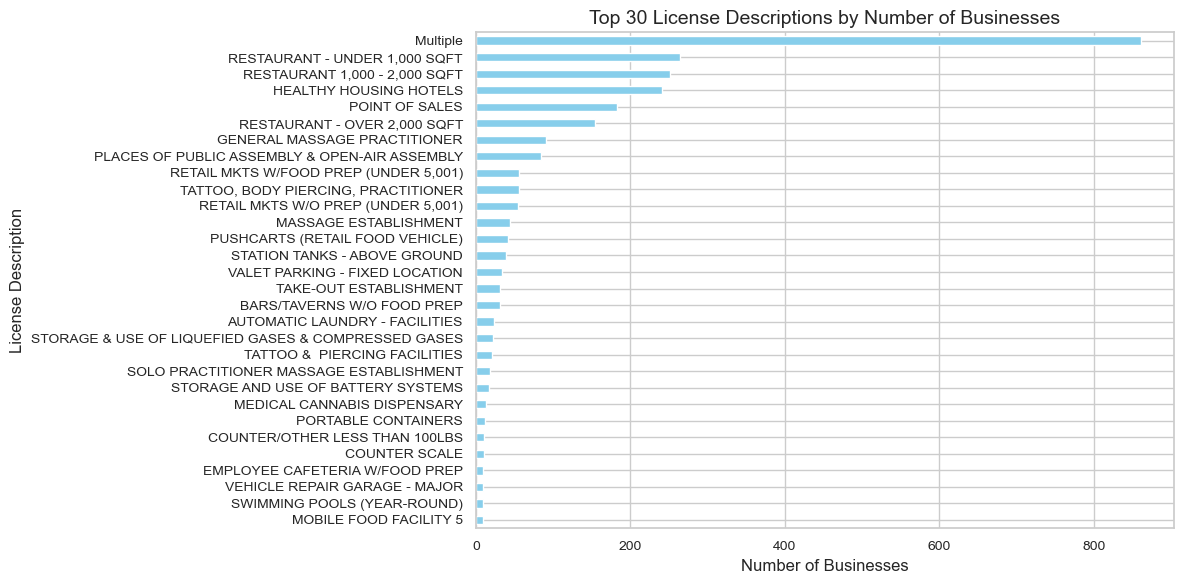

ValueError: Could not interpret value `year` for `x`. An entry with this name does not appear in `data`.

<Figure size 1200x600 with 0 Axes>

In [4]:
# Set Seaborn and Matplotlib styles
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
# Create a copy of the original DataFrame
eda_df = sfo_df.copy()
# Filter the DataFrame based on conditions
eda_df = eda_df[
    (eda_df['lic_code_description'] != 'Unknown') &
    (eda_df['neighborhoods_analysis_boundaries'] != 'Unknown') &
    (eda_df['supervisor_district'].notna())
]
# Create a new column for the year from the DBA start date
eda_df['year'] = eda_df['dba_start_date'].dt.year
# Save the cleaned data to a CSV file

sfo_df.to_csv('../data/modeling_dataset_full.csv', index=False)

# --- 1. Horizontal Bar: Top 30 License Descriptions Total Count ---
top_lics = sfo_df['lic_code_description'].value_counts().nlargest(30)
plt.figure()
top_lics.sort_values().plot(kind='barh', color='skyblue')
plt.title('Top 30 License Descriptions by Number of Businesses',fontsize=14)
plt.xlabel('Number of Businesses', fontsize=12)
plt.ylabel('License Description', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# --- 2. Histplot: Registrations per Year ---
plt.figure()
sns.histplot(data=sfo_df, x='year', binwidth=1, color='teal')
plt.title('Business Registrations Per Year (Starting 1950)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Registrations', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlim(left=1950)  # Set the x-axis to start from 1950
plt.tight_layout()
plt.show()

# --- 3. Horizontal Bar Plot: Average Business Age for Top 30 License Descriptions ---
lic_age_avg = (
    sfo_df[sfo_df['lic_code_description'].isin(top_lics.index)]
    .groupby('lic_code_description')['business_age']
    .mean()
    .loc[top_lics.index] 
)

plt.figure()
lic_age_avg.sort_values().plot(kind='barh', color='mediumpurple')
plt.title('Average Business Age for Top 30 License Descriptions', fontsize=14)
plt.xlabel('Average Business Age (Years)', fontsize=12)
plt.ylabel('License Description', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# --- 4. Horizontal Bar: Top Neighborhoods ---
top_neigh = sfo_df['neighborhoods_analysis_boundaries'].value_counts().nlargest(30)
plt.figure()
top_neigh.sort_values().plot(kind='barh', color='orange')
plt.title('Top 30 Neighborhoods by Number of Businesses', fontsize=14)
plt.xlabel('Number of Businesses', fontsize=12)
plt.ylabel('Neighborhood', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


# --- 5. Barplot: Business Registrations per Decade  ---
sfo_df['decade'] = (sfo_df['year'] // 10) * 10

# Ensure that the first decade is from 1950
decade_counts = sfo_df[sfo_df['decade'] >= 1950]['decade'].value_counts().sort_index()

plt.figure()
sns.barplot(x=decade_counts.index.astype(int), y=decade_counts.values, color='coral')
plt.title('Business Registrations Over 10-Year Periods', fontsize=14)
plt.xlabel('Decade', fontsize=12)
plt.ylabel('Number of Registrations', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Extract the year of registration
sfo_df['start_year'] = sfo_df['dba_start_date'].dt.year
open_counts = sfo_df['start_year'].value_counts().sort_index()
sfo_df['business_age'] = pd.to_numeric(sfo_df['business_age'], errors='coerce')
sfo_df['closure_year'] = sfo_df['start_year'] + sfo_df['business_age'].astype(int)

# --- 6. Count administrative closures per year 
# Filter data to start from 1950 for both openings and closures
open_counts = sfo_df[sfo_df['administratively_closed'] == 0]
open_counts = open_counts[open_counts['closure_year'] >= 1950]['closure_year'].value_counts().sort_index()

closed_counts = sfo_df[sfo_df['administratively_closed'] == 1]
closed_counts = closed_counts[closed_counts['closure_year'] >= 1950]['closure_year'].value_counts().sort_index()

# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(open_counts.index, open_counts.values, label='Business Openings', marker='o')
plt.plot(closed_counts.index, closed_counts.values, label='Administrative Closures', marker='x', linestyle='--', color='red')
plt.title("Observed Business Openings and Administrative Closures Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Businesses")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##  Key Insights from the Exploratory Data Analysis (EDA)

The following insights were gathered from the visualizations and analysis conducted on the San Francisco business registration dataset. These findings provide a deeper understanding of the trends, distributions, and potential areas of interest for further investigation.


###  1. Top 30 License Descriptions by Number of Businesses
The chart of the **Top 30 License Descriptions** reveals that the "Multiple license" category dominates with over **500 businesses** registered under this license description. This suggests that a significant portion of businesses operate under multiple licenses, potentially indicating diverse business activities or multi-faceted business models in San Francisco. 

- **Key Takeaway:** "Multiple license" businesses are substantial, and further investigation into this category could yield insights into business diversity.


### 2. Business Registrations Per Year (Starting 2000)
The histogram displaying **Business Registrations Per Year** shows a clear trend: **2015** saw the highest number of business registrations, with over **2,500 businesses** registered. This year marks a peak in entrepreneurial activity, potentially reflecting a favorable economic environment or policy changes that encouraged business formation.

- **Key Takeaway:** The growth of business registrations peaked in 2015, and understanding the factors contributing to this spike could be useful for policymakers or urban planners.


###  3. Average Business Age for Top 30 License Descriptions
In terms of **Average Business Age** for the top 30 license descriptions, **"Storage and Battery Systems"** stands out with an average business age of over **32 years**. This indicates that businesses in this category are relatively mature, suggesting stability and long-term viability.

- **Key Takeaway:** The "Storage and Battery Systems" sector is an established industry, and businesses within this group have a long track record, which could influence their approach to innovation, expansion, or market competition.


### 4. Top 5 Neighborhoods by Business Count
The analysis of businesses by neighborhood highlights the **Top 5 Neighborhoods** in San Francisco, which are:

1. **Financial District South Beach**
2. **Chinatown**
3. **Nob Hill**
4. **Russian Hill**
5. **Tenderloin**

These neighborhoods have the highest concentrations of businesses, reflecting areas of significant economic activity. The presence of these neighborhoods as business hubs suggests the importance of these areas in the city's economy.

- **Key Takeaway:** The identified neighborhoods are economic focal points in San Francisco, and further analysis into the types of businesses within these areas could provide more detailed insights into industry clustering and neighborhood dynamics.


### 5. Business Registrations Over 10-Year Periods
A closer look at **Business Registrations Over 10-Year Periods** reveals that the **2010s decade** (2010-2019) saw the highest number of business registrations, with over **15,000 businesses** registered during this period. This marks the 2010s as a decade of robust entrepreneurial growth in San Francisco, possibly driven by economic conditions, the rise of technology, and the growth of startup culture.

- **Key Takeaway:** The 2010s were a period of significant entrepreneurial activity, and exploring the drivers behind this surge can provide valuable insights into factors that encourage new business formation.


### 6. Business Openings vs. Administrative Closures Over Time
One of the most striking findings from the time series plot of **Business Openings vs. Administrative Closures** is the drastic increase in **administratively closed businesses**, which eventually surpassed the number of new business registrations. This trend appears to have accelerated as business registrations slowed down and administrative closures surged, especially post-2015.

### Findings
The rise in administrative closures is a concerning trend. It may indicate business struggles, regulatory challenges, or other external pressures. This signals a need for further analysis into the causes behind these closures and how they impact the local economy and business environment.

